# Importación de librerias

In [1]:
# Basic packages
import pandas as pd 
import numpy as np
import re
import collections
import matplotlib.pyplot as plt
from pathlib import Path

# Packages for data preparation
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import load_files
import nltk

# Packages for modeling
from keras import models
from keras import layers
from keras import regularizers

Using TensorFlow backend.


# Definición de constantes

In [2]:
NB_WORDS = 10000  # Parameter indicating the number of words we'll put in the dictionary
VAL_SIZE = 1000  # Size of the validation set
NB_START_EPOCHS = 50  # Number of epochs we usually start to train with
BATCH_SIZE = 512  # Size of the batches used in the mini-batch gradient descent
MAX_LEN = 1408  # Maximum number of words in a sequence
GLOVE_DIM = 300  # Number of dimensions of the GloVe word embeddings

# Definición de funciones

In [3]:
def deep_model(model, X_train, y_train, X_valid, y_valid):
    '''
    Function to train a multi-class model. The number of epochs and 
    batch_size are set by the constants at the top of the
    notebook. 
    
    Parameters:
        model : model with the chosen architecture
        X_train : training features
        y_train : training target
        X_valid : validation features
        Y_valid : validation target
    Output:
        model training history
    '''
    model.compile(optimizer='rmsprop'
                  , loss='categorical_crossentropy'
                  , metrics=['accuracy'])
    
    history = model.fit(X_train
                       , y_train
                       , epochs=NB_START_EPOCHS
                       , batch_size=BATCH_SIZE
                       , validation_data=(X_valid, y_valid)
                       , verbose=1)
    return history

def eval_metric(history, metric_name):
    '''
    Function to evaluate a trained model on a chosen metric. 
    Training and validation metric are plotted in a
    line chart for each epoch.
    
    Parameters:
        history : model training history
        metric_name : loss or accuracy
    Output:
        line chart with epochs of x-axis and metric on
        y-axis
    '''
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]

    e = range(1, NB_START_EPOCHS + 1)

    plt.plot(e, metric, 'bo', label='Train ' + metric_name)
    plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
    plt.legend()
    plt.show()

def test_model(model, X_train, y_train, X_test, y_test, epoch_stop):
    '''
    Function to test the model on new data after training it
    on the full training data with the optimal number of epochs.
    
    Parameters:
        model : trained model
        X_train : training features
        y_train : training target
        X_test : test features
        y_test : test target
        epochs : optimal number of epochs
    Output:
        test accuracy and test loss
    '''
    model.fit(X_train
              , y_train
              , epochs=epoch_stop
              , batch_size=BATCH_SIZE
              , verbose=0)
    results = model.evaluate(X_test, y_test)
    
    return results

def remove_stopwords(input_text):
    '''
    Function to remove English stopwords from a Pandas Series.
    
    Parameters:
        input_text : text to clean
    Output:
        cleaned Pandas Series 
    '''
    stopwords_list = stopwords.words('english')
    # Some words which might indicate a certain sentiment are kept via a whitelist
    whitelist = ["n't", "not", "no"]
    words = input_text.split() 
    clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
    return " ".join(clean_words)

# Lectura y linpieza de datos

In [4]:
data = load_files('dataset/txt_sentoken', shuffle=False,encoding="utf-8")
# df = pd.read_csv('Tweets.csv')

In [5]:
df = pd.DataFrame(data= np.c_[data['data'], data['target']],columns= ['text','target'])

In [6]:
df.head()

,text,target
0,"plot : two teen couples go to a church party ,...",0
1,the happy bastard's quick movie review \ndamn ...,0
2,it is movies like these that make a jaded movi...,0
3,""" quest for camelot "" is warner bros . ' firs...",0
4,synopsis : a mentally unstable man undergoing ...,0


In [7]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/lprone/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
df.text = df.text.apply(remove_stopwords)

### Partición de datos en entrenamiento y test

In [9]:
X_train, X_test, y_train, y_test = train_test_split(df.text, df.target, test_size=0.1, random_state=37)
print('# Train data samples:', X_train.shape[0])
print('# Test data samples:', X_test.shape[0])
assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]

# Train data samples: 1800
# Test data samples: 200


### Convierto variables a categorías

In [10]:
tk = Tokenizer(num_words=NB_WORDS,
               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
               lower=True,
               split=" ")
tk.fit_on_texts(X_train)

X_train_seq = tk.texts_to_sequences(X_train)
X_test_seq = tk.texts_to_sequences(X_test)

### Analizo cantidad de palabras en reviews
Before we can compute the word embeddings, we need to make sure the sequences are of equal length. In the example below, we truncate sequences to length MAX_LEN, or pad them with zeroes to achieve this. First, we'll have a look at the length of the (cleaned) tweets.

In [11]:
X_train.apply(lambda x: len(x.split(' '))).describe()

count    1800.000000
mean      354.344444
std       152.919970
min         8.000000
25%       251.750000
50%       333.000000
75%       428.000000
max      1408.000000
Name: text, dtype: float64

Based on the figures above we will set MAX_LEN to 24. So this means we will not be truncating any words, only pad with zeros. This is to avoid to lose information as the tweets are rather short.

In [12]:
MAX_LEN = 1408

In [13]:
X_train_seq_trunc = pad_sequences(X_train_seq, maxlen=MAX_LEN)
X_test_seq_trunc = pad_sequences(X_test_seq, maxlen=MAX_LEN)

### Codifico etiquetas

In [14]:
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)
y_train_oh = to_categorical(y_train_le)
y_test_oh = to_categorical(y_test_le)

### Genero partición para validación

In [15]:
X_train_emb, X_valid_emb, y_train_emb, y_valid_emb = train_test_split(X_train_seq_trunc, y_train_oh, test_size=0.1, random_state=37)

assert X_valid_emb.shape[0] == y_valid_emb.shape[0]
assert X_train_emb.shape[0] == y_train_emb.shape[0]

print('Tamaño de conjunto de validación:',X_valid_emb.shape)

Tamaño de conjunto de validación: (180, 1408)


# Entrenamiento

## Modelo 1.

Se va a usar como primer modelo, un modelo secuencial cuya primer capa es la capa de embedding provista por keras entrenada con las palabras del conjunto de entrenamiento. A continuación se agrega una capa de flatten para adaptar las dimensiones de los vectores, y luego una capa densa de 300 neuronas previa a la salida.
Esta arquitectura se va a usar en para ambos embeddings (keras, preentrenado) y se va a entrenar la red durante 50 épocas

In [16]:
emb_model = models.Sequential()
emb_model.add(layers.Embedding(NB_WORDS, 8, input_length=MAX_LEN))
emb_model.add(layers.Flatten())
emb_model.add(layers.Dense(300, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
emb_model.add(layers.Dense(2, activation='softmax'))
emb_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1408, 8)           80000     
_________________________________________________________________
flatten_1 (Flatten)          (None, 11264)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 300)               3379500   
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 602       
Total params: 3,460,102
Trainable params: 3,460,102
Non-trainable params: 0
_________________________________________________________________


In [17]:
emb_history = deep_model(emb_model, X_train_emb, y_train_emb, X_valid_emb, y_valid_emb)

Train on 1620 samples, validate on 180 samples
Epoch 1/50
1620/1620 [==============================] - 2s 964us/step - loss: 4.9824 - acc: 0.4969 - val_loss: 2.5663 - val_acc: 0.5000
Epoch 2/50
1620/1620 [==============================] - 1s 386us/step - loss: 2.2089 - acc: 0.5210 - val_loss: 1.5650 - val_acc: 0.5000
Epoch 3/50
1620/1620 [==============================] - 1s 444us/step - loss: 1.3958 - acc: 0.5346 - val_loss: 1.0975 - val_acc: 0.5278
Epoch 4/50
1620/1620 [==============================] - 1s 481us/step - loss: 1.0352 - acc: 0.5123 - val_loss: 0.8931 - val_acc: 0.5167
Epoch 5/50
1620/1620 [==============================] - 1s 482us/step - loss: 0.8518 - acc: 0.5179 - val_loss: 0.8148 - val_acc: 0.5056
Epoch 6/50
1620/1620 [==============================] - 1s 487us/step - loss: 0.7648 - acc: 0.5549 - val_loss: 0.7676 - val_acc: 0.5056
Epoch 7/50
1620/1620 [==============================] - 1s 480us/step - loss: 0.7213 - acc: 0.5716 - val_loss: 0.7277 - val_acc: 0.5722
E

Luego del entrenamiento se ve que la red obtiene aproximadamente un 80% de accuracy en el conjunto de validación

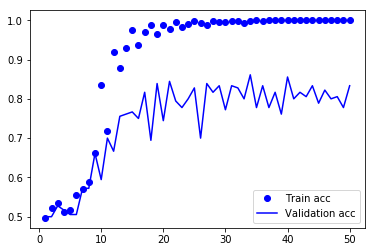

In [18]:
eval_metric(emb_history, 'acc')

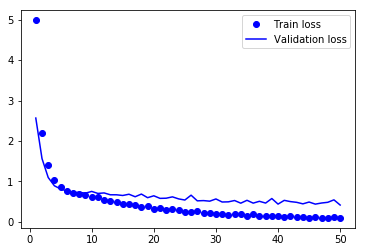

In [19]:
eval_metric(emb_history, 'loss')

In [20]:
emb_results = test_model(emb_model, X_train_seq_trunc, y_train_oh, X_test_seq_trunc, y_test_oh, 6)
print('/n')
print('Accuracy en conjunto de test: {0:.2f}%'.format(emb_results[1]*100))

200/200 [==============================] - 0s 408us/step
/n
Accuracy en conjunto de test: 88.50%



# Uso de embedding preentrenado


Se decidió usar el embedding [GloVe database](https://nlp.stanford.edu/projects/glove/) el cual provee embeddings de varias dimensiones preentrenados usando datos de tweets.  
Se optó por usar la versión de 300 dimensiones provista ya que en pruebas con embeddings de menor tamaño los resultados no fueron buenos.

In [21]:
glove_file = 'glove.6B.300d.txt'
emb_dict = {}
glove = open(glove_file)
for line in glove:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:], dtype='float32')
    emb_dict[word] = vector
glove.close()

### Matriz representativa de palabras

In [22]:
emb_matrix = np.zeros((NB_WORDS, GLOVE_DIM))

for w, i in tk.word_index.items():
    if i < NB_WORDS:
        vect = emb_dict.get(w)
        if vect is not None:
            emb_matrix[i] = vect
    else:
        break

## Modelo 2

In [23]:
glove_model = models.Sequential()
glove_model.add(layers.Embedding(NB_WORDS, GLOVE_DIM, input_length=MAX_LEN))
glove_model.add(layers.Flatten())
glove_model.add(layers.Dense(300, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
glove_model.add(layers.Dense(2, activation='softmax'))
glove_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1408, 300)         3000000   
_________________________________________________________________
flatten_2 (Flatten)          (None, 422400)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 300)               126720300 
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 602       
Total params: 129,720,902
Trainable params: 129,720,902
Non-trainable params: 0
_________________________________________________________________


Defino la capa de embedding con los pesos provistos por la matriz de palabras obtenida a partir del embedding preentrenado y las palabras del todas las reviews

In [24]:
glove_model.layers[0].set_weights([emb_matrix])
glove_model.layers[0].trainable = False

In [25]:
glove_history = deep_model(glove_model, X_train_emb, y_train_emb, X_valid_emb, y_valid_emb)

Train on 1620 samples, validate on 180 samples
Epoch 1/50
1620/1620 [==============================] - 36s 22ms/step - loss: 11.8154 - acc: 0.4870 - val_loss: 9.4293 - val_acc: 0.5000
Epoch 2/50
1620/1620 [==============================] - 20s 12ms/step - loss: 8.8320 - acc: 0.5049 - val_loss: 8.0915 - val_acc: 0.5000
Epoch 3/50
1620/1620 [==============================] - 20s 12ms/step - loss: 8.6213 - acc: 0.5253 - val_loss: 4.6217 - val_acc: 0.5444
Epoch 4/50
1620/1620 [==============================] - 20s 12ms/step - loss: 4.9292 - acc: 0.5500 - val_loss: 3.6034 - val_acc: 0.5889
Epoch 5/50
1620/1620 [==============================] - 20s 12ms/step - loss: 4.4093 - acc: 0.6278 - val_loss: 6.1076 - val_acc: 0.5000
Epoch 6/50
1620/1620 [==============================] - 20s 12ms/step - loss: 3.7229 - acc: 0.5815 - val_loss: 2.5556 - val_acc: 0.5944
Epoch 7/50
1620/1620 [==============================] - 20s 12ms/step - loss: 1.3815 - acc: 0.8877 - val_loss: 1.5302 - val_acc: 0.6556


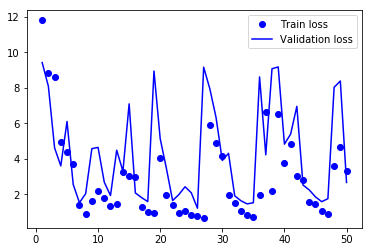

In [26]:
eval_metric(glove_history, 'loss')

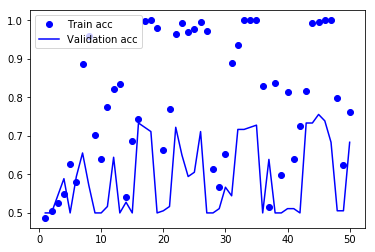

In [27]:
eval_metric(glove_history, 'acc')

In [28]:
glove_results = test_model(glove_model, X_train_seq_trunc, y_train_oh, X_test_seq_trunc, y_test_oh, 3)
print('/n')
print('Accuracy en conjunto de test: {0:.2f}%'.format(glove_results[1]*100))

200/200 [==============================] - 2s 12ms/step
/n
Accuracy en conjunto de test: 70.00%


# Conclusión  
Luego de la comparación de ambos embeddings vemos que el primer modelo donde se definió una capa de embedding entrenada solo con palabras de las reviews obtuvo resultados considerablemente superiores a los obtenidos por el embeding preentrenado, esto indica que el embedding preentrenado puede tener demasiada información no relevante para el problema que se esta intentando resolver.  
Ademas, comparando los resultados con los obtenidos en el ejercicio 1 se ve que agregar una capa de embedding entrenada con los datos de reviews mejora 5% la performance obtenida, por lo que se considera una opción a tener en cuenta en análisis de textos.